In [1]:
import numpy as np
import pandas as pd
from tableone import TableOne
from lifelines import CoxPHFitter, plotting, KaplanMeierFitter
from sklearn.preprocessing import LabelEncoder
from lifelines.statistics import logrank_test

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use('ggplot')

plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#505050'
plt.rcParams['axes.labelcolor']= '#505050'
plt.rcParams['xtick.color'] = '#505050'
plt.rcParams['ytick.color'] = '#505050'
plt.rcParams['font.size']= 11

In [3]:
pd.set_option('max_columns', None)

### COMPAS

In [4]:
df_compas = pd.read_csv("cox-parsed.csv")

In [5]:
df_compas.head(2)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,(F3),Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0
1,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,(F3),Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,334,961,0


In [6]:
df_compas.shape

(13419, 52)

In [7]:
df_compas = df_compas.loc[df_compas.end > df_compas.start]

In [8]:
df_compas = df_compas.loc[df_compas.score_text.notnull()]

In [9]:
df_compas.drop_duplicates(subset=["id"], inplace=True)

In [10]:
df_compas["duration"] = df_compas["end"] - df_compas["start"]

In [11]:
df_compas.loc[df_compas.score_text == 'Low', "score_factor"] = 0
df_compas.loc[df_compas.score_text == 'Medium', "score_factor"] = 1
df_compas.loc[df_compas.score_text == 'High', "score_factor"] = 2

In [12]:
df_compas.loc[df_compas.score_text == "High", "score_text"] = "factor_c_high"
df_compas.loc[df_compas.score_text == "Low", "score_text"] = "factor_a_low"
df_compas.loc[df_compas.score_text == "Medium", "score_text"] = "factor_b_medium"

In [13]:
df_compas.loc[df_compas.race == "Caucasian", "race"] = "0_Caucasian"

In [14]:
df_compas["score_text"] = df_compas["score_text"].astype("category") 
df_compas["race"] = df_compas["race"].astype("category") 

In [15]:
df_compas.shape

(10314, 54)

In [16]:
df_compas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10314 entries, 0 to 13417
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       10314 non-null  int64   
 1   name                     10314 non-null  object  
 2   first                    10314 non-null  object  
 3   last                     10314 non-null  object  
 4   compas_screening_date    10314 non-null  object  
 5   sex                      10314 non-null  object  
 6   dob                      10314 non-null  object  
 7   age                      10314 non-null  int64   
 8   age_cat                  10314 non-null  object  
 9   race                     10314 non-null  category
 10  juv_fel_count            10314 non-null  int64   
 11  decile_score             10314 non-null  int64   
 12  juv_misd_count           10314 non-null  int64   
 13  juv_other_count          10314 non-null  int64   
 14  priors

#### EDA

[]

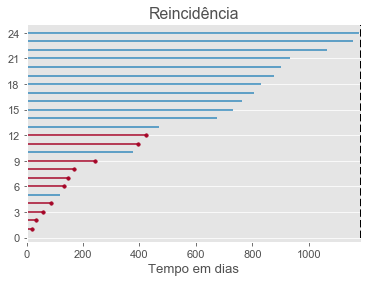

In [17]:
# Plotting only n individuals
df = df_compas.sample(n=25, random_state=0)

durations = df.duration.values
events = df.event.values

ax = plotting.plot_lifetimes(durations=durations, event_observed=events)
ax.set_xlim(0, 1186)
ax.vlines(1186, 0, 25, lw=2, linestyles='--')
ax.grid(axis='x')
ax.set_xlabel("Tempo em dias")
ax.set_title("Reincidência")
plt.plot()

In [18]:
# Table One
columns = ["sex", "score_text"]
groupby = ['race']
nonnormal = ["age"]

# create an instance of TableOne with the input arguments
grouped_table = TableOne(df_compas, columns=columns, groupby=groupby, 
                         nonnormal=nonnormal, missing=False,
                         dip_test=True, normal_test=True, tukey_test=True)

# view tableone
grouped_table

Grouped by race                                                                                 
                                          Overall  0_Caucasian African-American      Asian    Hispanic Native American       Other
n                                           10314         3569             5147         51         944              32         571
sex, n (%)        Female              2112 (20.5)   862 (24.2)       973 (18.9)    5 (9.8)  158 (16.7)        7 (21.9)  107 (18.7)
                  Male                8202 (79.5)  2707 (75.8)      4174 (81.1)  46 (90.2)  786 (83.3)       25 (78.1)  464 (81.3)
score_text, n (%) factor_a_low        5751 (55.8)  2372 (66.5)      2184 (42.4)  38 (74.5)  684 (72.5)       16 (50.0)  457 (80.0)
                  factor_b_medium     2611 (25.3)   800 (22.4)      1543 (30.0)   9 (17.6)  168 (17.8)        9 (28.1)   82 (14.4)
                  factor_c_high       1952 (18.9)   397 (11.1)      1420 (27.6)    4 (7.8)    92 (9.7)        7 (21.9)    32 (5.6)

Text(0.5, 1.0, 'Distribuição de idade')

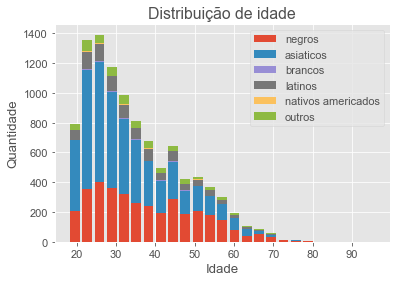

In [19]:
# Age distribution
ax = df_compas.pivot(columns='race').age.plot(kind = 'hist', stacked=True, bins=25, rwidth=0.8)
ax.legend(labels=['negros', 'asiaticos', 'brancos', 'latinos', 'nativos americados', 'outros'])
plt.xlabel('Idade')
plt.ylabel('Quantidade')
plt.title('Distribuição de idade')

Text(0.5, 1.0, 'Distribuição de prisões anteriores')

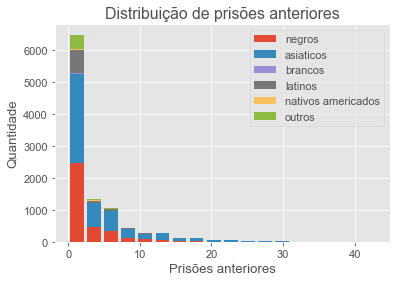

In [20]:
# prior arrest distribution
ax = df_compas.pivot(columns='race').priors_count.plot(kind = 'hist', stacked=True, bins=18, rwidth=0.8)
ax.legend(labels=['negros', 'asiaticos', 'brancos', 'latinos', 'nativos americados', 'outros'])
plt.xlabel('Prisões anteriores')
plt.ylabel('Quantidade')
plt.title('Distribuição de prisões anteriores')

Text(0.5, 1.0, 'Distribuição')

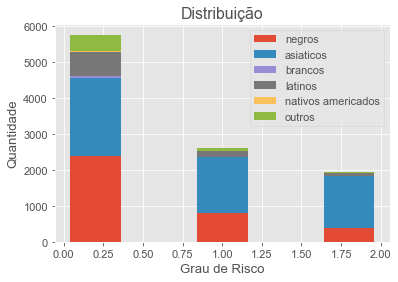

In [21]:
# Classificacao COMPAS de risco
ax = df_compas.pivot(columns='race').score_factor.plot(kind = 'hist', stacked=True, bins=5, rwidth=0.8)
ax.legend(labels=['negros', 'asiaticos', 'brancos', 'latinos', 'nativos americados', 'outros'])
plt.xlabel('Grau de Risco')
plt.ylabel('Quantidade')
plt.title('Distribuição')

#### Kaplan Meier

In [22]:
T = df_compas["duration"]
E = df_compas["event"]

In [23]:
kmf = KaplanMeierFitter()
kmf.fit(T, E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 10314 total observations, 7555 right-censored observations>

In [42]:
def plot_km(df1, df2, label1, label2, df3=None, label3=None):
    ax = plt.subplot(111)
    
    kmf.fit(T[df1], event_observed=E[df1], label=label1)
    kmf.plot_survival_function()

    kmf.fit(T[df2], event_observed=E[df2], label=label2)
    kmf.plot_survival_function(ax=ax)
    
    if label3:
        kmf.fit(T[df3], event_observed=E[df3], label=label3)
        kmf.plot_survival_function(ax=ax)        

    ax.set_ylabel('S(t|z)')
    ax.set_xlabel('Tempo')

In [25]:
def logrank(df1, df2):
    results = logrank_test(df1.duration, df2.duration, event_observed_A=df1.event, event_observed_B=df2.event)
    return print("stats: " + str(results.test_statistic) + " p-value: " + str(results.p_value))

In [28]:
dem_afam = (df_compas["race"] == "African-American")
dem_cau = (df_compas["race"] == "0_Caucasian")

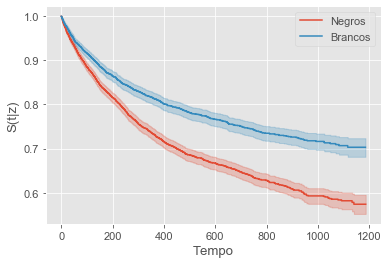

In [29]:
plot_km(dem_afam, dem_cau, "Negros", "Brancos")

In [30]:
df_black = df_compas.loc[df_compas["race"] == "African-American"]
df_white = df_compas.loc[df_compas["race"] == "0_Caucasian"]

In [31]:
logrank(df_black, df_white)

stats: 95.28051660881665 p-value: 1.6523136025500363e-22


In [32]:
dem_fem = (df_compas["sex"] == "Female")
dem_male = (df_compas["sex"] == "Male")

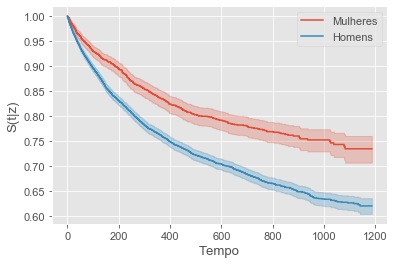

In [33]:
plot_km(dem_fem, dem_male, "Mulheres", "Homens")

In [34]:
df_fem = df_compas.loc[df_compas["sex"] == "Female"]
df_male = df_compas.loc[df_compas["sex"] == "Male"]

In [35]:
logrank(df_fem, df_male)

stats: 68.24933039347303 p-value: 1.4407596078094683e-16


In [36]:
dem_low = (df_compas["score_text"] == "factor_a_low")
dem_med = (df_compas["score_text"] == "factor_b_medium")
dem_hi = (df_compas["score_text"] == "factor_c_high")

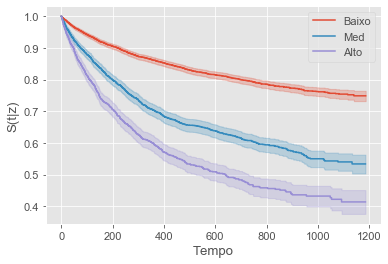

In [43]:
plot_km(dem_low, dem_med, "Baixo", "Med", dem_hi, "Alto")

In [45]:
df_low = df_compas.loc[df_compas["score_text"] == "factor_a_low"]
df_med = df_compas.loc[df_compas["score_text"] == "factor_b_medium"]
df_high = df_compas.loc[df_compas["score_text"] == "factor_c_high"]

In [46]:
logrank(df_low, df_med)

stats: 321.48480147218646 p-value: 6.87830827471695e-72


In [47]:
logrank(df_low, df_high)

stats: 708.086971930778 p-value: 5.213786780310805e-156


In [48]:
logrank(df_med, df_high)

stats: 66.72444887213543 p-value: 3.122384281547892e-16


#### Cox

In [49]:
cph1 = CoxPHFitter()
formula1 = "score_text"
cph1.fit(df_compas, duration_col='duration', event_col='event', formula=formula1)

<lifelines.CoxPHFitter: fitted with 10314 total observations, 7555 right-censored observations>

In [50]:
cph1.print_summary()

<lifelines.CoxPHFitter: fitted with 10314 total observations, 7555 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 10314
number of events observed = 2759
   partial log-likelihood = -24097.25
         time fit was run = 2021-09-21 02:25:03 UTC

---
                                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                             
score_text[T.factor_b_medium]   0.79       2.20       0.05             0.70             0.88                 2.01                 2.40
score_text[T.factor_c_high]     1.19       3.30       0.05             1.10             1.29                 3.01                 3.62

                                  z      p   -log2(p)
covariate                                            
score_text[T.factor_b_medium] 17.43 <0.005     223.73
score_text[T.factor_c_high]   25.26 <0.005     465.13
---
Concordance = 0.63
Partial AIC = 48198.51
log-likelihood ratio test = 681.06 on 2 df
-log2(p) of ll-ratio test = 491.28

In [51]:
cph1.check_assumptions(df_compas)

Proportional hazard assumption looks okay.


[]

In [52]:
cph2 = CoxPHFitter()
formula2="decile_score"
cph2.fit(df_compas, duration_col='duration', event_col='event', formula=formula2)

<lifelines.CoxPHFitter: fitted with 10314 total observations, 7555 right-censored observations>

In [53]:
cph2.print_summary()

<lifelines.CoxPHFitter: fitted with 10314 total observations, 7555 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 10314
number of events observed = 2759
   partial log-likelihood = -24035.89
         time fit was run = 2021-09-21 02:25:04 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
decile_score   0.19       1.21       0.01             0.17             0.20                 1.19                 1.22

                 z      p   -log2(p)
covariate                           
decile_score 28.69 <0.005     598.86
---
Concordance = 0.66
Partial AIC = 48073.77
log-likelihood ratio test = 803.80 on 1 df
-log2(p) of ll-ratio test = 584.97

In [54]:
cph3 = CoxPHFitter()
formula3 = "race + score_text + race * score_text"
cph3.fit(df_compas, duration_col='duration', event_col='event', formula=formula3)

<lifelines.CoxPHFitter: fitted with 10314 total observations, 7555 right-censored observations>

In [55]:
cph3.print_summary()

<lifelines.CoxPHFitter: fitted with 10314 total observations, 7555 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 10314
number of events observed = 2759
   partial log-likelihood = -24072.72
         time fit was run = 2021-09-21 02:25:05 UTC

---
                                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                                      
race[T.African-American]                                 0.29       1.34       0.07             0.16             0.42                 1.18                 1.53
race[T.Asian]                                           -1.32       0.27       0.71            -2.71             0.06                 0.07                 1.07
race[T.Hispanic]                                         0.00       1.00       0.10            -0.20             0.20                 0.82                 1.23
race[T.Native American]                                -12.38       0.00     297.20          -594.87           570.12                 0.00            3.97e+247
race[T.Other]                                           -0.05       0.95       0.12            -0.30             0.19                 0.74                 1.21
score_text[T.factor_b_medium]                            0.83       2.29       0.08             0.67             0.99                 1.96                 2.68
score_text[T.factor_c_high]                              1.28       3.59       0.10             1.09             1.47                 2.97                 4.33
race[T.African-American]:score_text[T.factor_b_medium]  -0.16       0.85       0.10            -0.36             0.04                 0.70                 1.04
race[T.Asian]:score_text[T.factor_b_medium]              1.28       3.58       0.92            -0.52             3.07                 0.59                21.58
race[T.Hispanic]:score_text[T.factor_b_medium]          -0.08       0.92       0.19            -0.44             0.29                 0.64                 1.33
race[T.Native American]:score_text[T.factor_b_medium]   12.39   2.41e+05     297.20          -570.11           594.89                 0.00            2.27e+258
race[T.Other]:score_text[T.factor_b_medium]             -0.17       0.84       0.25            -0.66             0.32                 0.51                 1.38
race[T.African-American]:score_text[T.factor_c_high]    -0.26       0.77       0.11            -0.49            -0.04                 0.62                 0.96
race[T.Asian]:score_text[T.factor_c_high]                2.16       8.68       0.92             0.36             3.96                 1.44                52.45
race[T.Hispanic]:score_text[T.factor_c_high]            -0.15       0.86       0.22            -0.58             0.27                 0.56                 1.32
race[T.Native American]:score_text[T.factor_c_high]     12.54   2.80e+05     297.20          -569.96           595.04                 0.00            2.64e+258
race[T.Other]:score_text[T.factor_c_high]                0.46       1.59       0.28            -0.08             1.01                 0.92                 2.74

                                                           z      p   -log2(p)
covariate                                                                     
race[T.African-American]                                4.38 <0.005      16.38
race[T.Asian]                                          -1.87   0.06       4.02
race[T.Hispanic]                                        0.04   0.97       0.04
race[T.Native American]                                -0.04   0.97       0.05
race[T.Other]                                          -0.44   0.66       0.60
score_text[T.factor_b_medium]        

ICI =  0.011107176801555175
E50 =  0.014691141330005375


/Users/bruna/miniconda3/envs/fairness/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/bruna/miniconda3/envs/fairness/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


(<matplotlib.axes._subplots.AxesSubplot at 0x1a1bca0f98>,
 0.011107176801555175,
 0.014691141330005375)

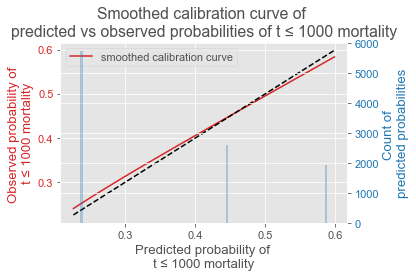

In [56]:
from lifelines.calibration import survival_probability_calibration

survival_probability_calibration(cph1, df_compas, t0=1000)

#### Predictions

In [57]:
censored_subjects_low = df_compas.loc[(~df_compas['event'].astype(bool)) & (df_compas['score_text'] == 'factor_a_low')]
censored_subjects_last_obs_low = censored_subjects_low['duration']

censored_subjects_med = df_compas.loc[(~df_compas['event'].astype(bool)) & (df_compas['score_text'] == 'factor_b_medium')]
censored_subjects_last_obs_med = censored_subjects_med['duration']

censored_subjects_hi = df_compas.loc[(~df_compas['event'].astype(bool)) & (df_compas['score_text'] == 'factor_c_high')]
censored_subjects_last_obs_hi = censored_subjects_hi['duration']

# predict new survival function
pred_low = cph1.predict_survival_function(censored_subjects_low, conditional_after=censored_subjects_last_obs_low)
pred_med = cph1.predict_survival_function(censored_subjects_med, conditional_after=censored_subjects_last_obs_med)
pred_hi = cph1.predict_survival_function(censored_subjects_hi, conditional_after=censored_subjects_last_obs_hi)

In [58]:
def survival_curve_median_calc(surv1, surv2, surv3):
    # Median and standard deviation
    df_surv_median1 = surv1.median(axis=1)
    df_surv_std1 = surv1.std(axis=1)
    
    df_surv_median2 = surv2.median(axis=1)
    df_surv_std2 = surv2.std(axis=1)
    
    df_surv_median3 = surv3.median(axis=1)
    df_surv_std3 = surv3.std(axis=1)

    return df_surv_median1, df_surv_std1, df_surv_median2, df_surv_std2, df_surv_median3, df_surv_std3


def survival_curve_plot(surv1, surv2, surv3, label1, label2, label3):
    df_surv_median1, df_surv_std1, df_surv_median2, df_surv_std2, df_surv_median3, df_surv_std3 = survival_curve_median_calc(surv1, surv2, surv3)

    # 95% Confidence interval
    ci1_left = surv1.quantile(0.025, axis=1)
    ci1_right = surv1.quantile(0.975, axis=1)
    ci2_left = surv2.quantile(0.025, axis=1)
    ci2_right = surv2.quantile(0.975, axis=1)

    # Plot curves
    ax = df_surv_median1.plot(label=label1, linestyle='--')
    #ax.fill_between(df_surv_median1.index, ci1_left, ci1_right, alpha=0.2, facecolor='turquoise')

    ax.plot(df_surv_median2, label=label2, linestyle='-.')
    #ax.fill_between(df_surv_median2.index, ci2_left, ci2_right, alpha=0.2, facecolor='slateblue')
    
    ax.plot(df_surv_median3, label=label3, linestyle=':')

    plt.legend(loc="lower left")
    plt.ylabel('S(t | x)')
    plt.xlabel('Time')

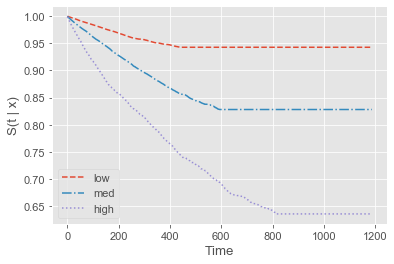

In [59]:
survival_curve_plot(pred_low, pred_med, pred_hi, "low", "med", "high")

In [60]:
def prediction_by_score_text(cph, df):
    censored_subjects_low = df.loc[(~df['event'].astype(bool)) & (df['score_text'] == 'factor_a_low')]
    censored_subjects_last_obs_low = censored_subjects_low['duration']

    censored_subjects_med = df.loc[(~df['event'].astype(bool)) & (df['score_text'] == 'factor_b_medium')]
    censored_subjects_last_obs_med = censored_subjects_med['duration']

    censored_subjects_hi = df.loc[(~df['event'].astype(bool)) & (df['score_text'] == 'factor_c_high')]
    censored_subjects_last_obs_hi = censored_subjects_hi['duration']
    
    # predict new survival function
    pred_low = cph.predict_survival_function(censored_subjects_low, conditional_after=censored_subjects_last_obs_low)
    pred_med = cph.predict_survival_function(censored_subjects_med, conditional_after=censored_subjects_last_obs_med)
    pred_hi = cph.predict_survival_function(censored_subjects_hi, conditional_after=censored_subjects_last_obs_hi)
    
    return pred_low, pred_med, pred_hi

In [61]:
black = df_compas.loc[df_compas['race'] == "African-American"]
white = df_compas.loc[df_compas['race'] == "0_Caucasian"]

pred_low_black, pred_med_black, pred_hi_black = prediction_by_score_text(cph3, black)
pred_low_white, pred_med_white, pred_hi_white = prediction_by_score_text(cph3, white)

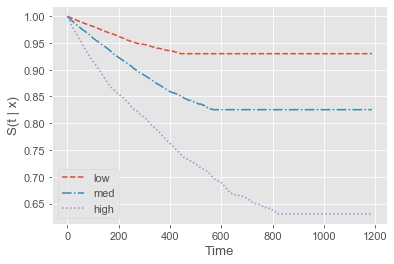

In [62]:
# black
survival_curve_plot(pred_low_black, pred_med_black, pred_hi_black, "low", "med", "high")

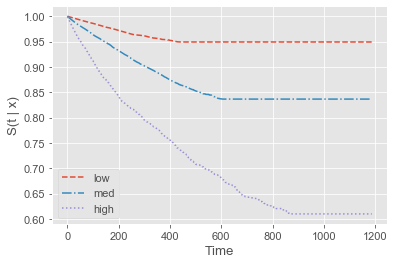

In [63]:
# white
survival_curve_plot(pred_low_white, pred_med_white, pred_hi_white, "low", "med", "high")

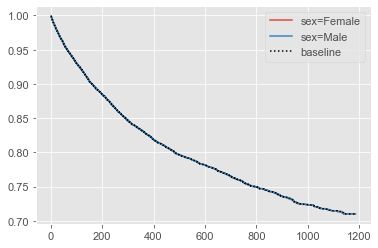

In [70]:
cph3.plot_partial_effects_on_outcome('sex', values=["Female", "Male"])

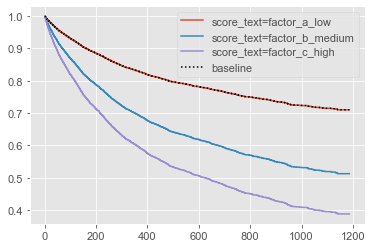

In [71]:
cph3.plot_partial_effects_on_outcome('score_text', values=["factor_a_low", "factor_b_medium", "factor_c_high"])

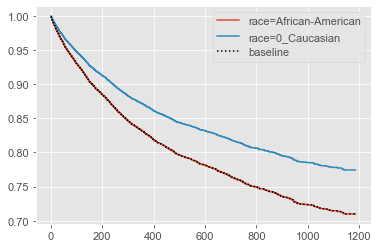

In [74]:
cph3.plot_partial_effects_on_outcome('race', values=["African-American", "0_Caucasian"])

#### Fairness